# Linear Regression and Gradient Descent

In this notebook we will see how we can perform linear regression in three different ways:
1. pure numpy
2. numpy + pytorch's autograd
3. pure pytorch

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
np.random.seed(0)
torch.manual_seed(0);

## The Problem

Suppose that we want to predict a real-valued quantity $y \in \mathbb{R}$ for a given input $\mathbf{x} \in \mathbb{R}^d$. This is known as **regression**.

The most common loss function for regression is the **quadractic loss** or **$\ell_2$ loss**:

$$
\ell_2(y, \hat{y}) = (y - \hat{y})^2
$$

The empirical risk becomes the **mean squared error (MSE)**:

$$
MSE(\theta) = \frac{1}{N} \sum\limits_{n=1}^{N} (y_n - f(\mathbf{x}_n; \theta))^2
$$

The model $f(\mathbf{x}_n; \theta)$ can be parameterized in many ways. In this lecture we will focus on a linear parameterization, leading to the well-known **Linear Regression** formulation:

$$
f(\mathbf{x}; \theta) = \mathbf{w}^\top \mathbf{x} + b = w_1 x_1 + w_2 x_2 + \cdots + w_D x_D + b
$$

where $\theta = (b, \mathbf{w})$ are the parameters of the model.

## Example

Let's create a synthetic regression dataset using `sklearn`'s `make_regression` function. For better visualization, we will use only a single feature.$

(100, 1) (100,)


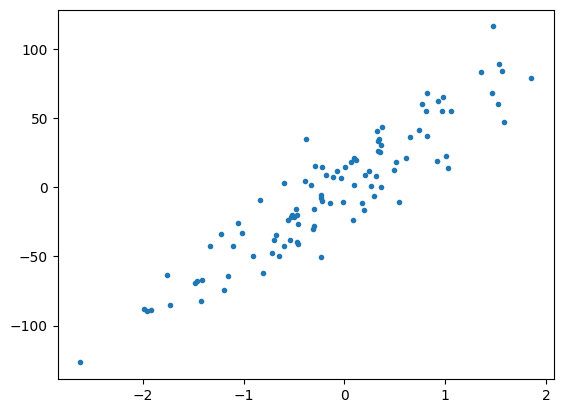

In [3]:
from sklearn.datasets import make_regression


n_features = 1
n_samples = 100

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    noise=20,
    random_state=42,
)

fix, ax = plt.subplots()
ax.plot(X, y, ".")
print(X.shape, y.shape)

For instance, by looking at the plot above, let's say that $w \approx 40$ and $b \approx 2$. Then, we would arrive at the following predictions (with vertical bars indicating the errors).

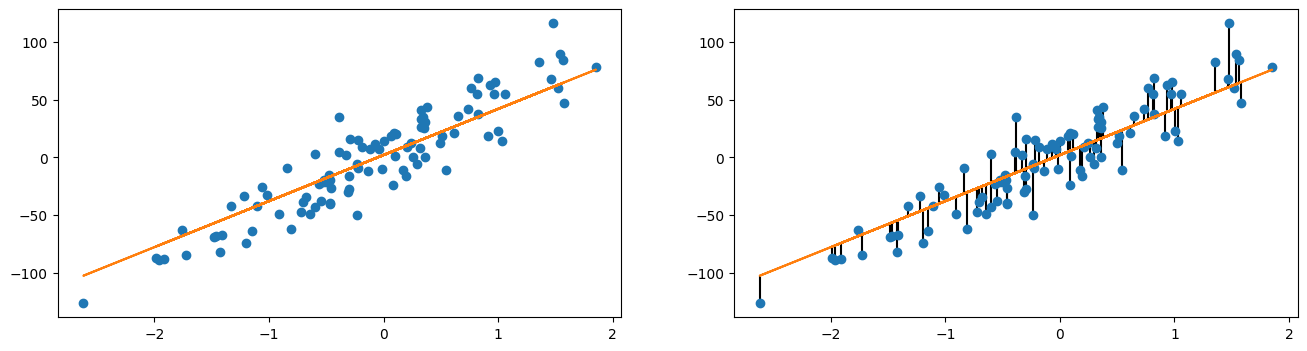

In [4]:
# our estimate
w = 40.0
b = 2.0
y_pred = w*X + b

# subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# left plot
axs[0].plot(X, y, 'o')
axs[0].plot(X, y_pred, '-')

# right plot
axs[1].vlines(X, y, y_pred, color='black')
axs[1].plot(X, y, 'o')
axs[1].plot(X, y_pred, '-')

By adjusting our parameters $\theta=(w, b)$, we can minimize the sum of squared errors to find the **least squares solution**

$$
\begin{align}
\hat{\theta} &= \arg\min_\theta MSE(\theta) \\
&= \arg\min_\theta \frac{1}{N} \sum\limits_{n=1}^{N} (y_n - f(\mathbf{x}_n; \theta))^2 \\
&= \arg\min_{w,b} \frac{1}{N} \sum\limits_{n=1}^{N} (y_n - (w \cdot x_n + b))^2
\end{align}
$$

Which can be found by taking the gradient of the loss function w.r.t. $\theta$.

<!--
<table>
    <tr>
        <td style="vertical-align: top; text-align: left; padding-right: 20px; background:#fff">
            <center><b>Solving for $b$:</b></center><br>
$$
\begin{align}
\hat{b} &= \text{solve}\bigg[ \frac{\partial MSE(\theta)}{\partial b} \bigg] \\
&= \text{solve}\bigg[ \frac{-2}{N} \sum\limits_{n=1}^{N} (y_n - w \cdot x_n - b) \cdot 1 \bigg] \\
&= \text{solve}\bigg[ \frac{-2}{N} \sum\limits_{n=1}^{N} (y_n - w \cdot x_n - b) \bigg]
\end{align}
$$

$$
\begin{align}
\frac{-2}{N} \sum\limits_{n=1}^{N} (y_n - w \cdot x_n - b) = 0 \\
\sum\limits_{n=1}^{N} b = \sum\limits_{n=1}^{N} (y_n - w \cdot x_n) \\
N b = \sum\limits_{n=1}^{N} (y_n - w \cdot x_n) \\
b = \frac{1}{N}\sum\limits_{n=1}^{N} (y_n - w \cdot x_n) \\
b = \bar{y} - w \bar{x} \\
\end{align}
$$
        </td>
        <td style="vertical-align: top; text-align: left; background:#fff">
            <center><b>Solving for $w$:</b></center><br>
$$
\begin{align}
\hat{w} &= \text{solve}\bigg[ \frac{\partial MSE(\theta)}{\partial w} \bigg] \\
&= \text{solve}\bigg[ \frac{-2}{N} \sum\limits_{n=1}^{N} (y_n - w \cdot x_n - b) \cdot (x_n) \bigg] \\
&= \text{solve}\bigg[ \frac{-2}{N} \sum\limits_{n=1}^{N} (y_n \cdot x_n - w \cdot x_n^2 - b \cdot x_n) \bigg]
\end{align}
$$

$$
\begin{align}
\frac{-2}{N} \sum\limits_{n=1}^{N} (y_n \cdot x_n - w \cdot x_n^2 - b \cdot x_n) = 0 \\
\sum\limits_{n=1}^{N} (y_n \cdot x_n - w \cdot x_n^2 - (\bar{y} - w \bar{x}) \cdot x_n) = 0 \\
\sum\limits_{n=1}^{N} (w \cdot x_n^2 - w \cdot \bar{x} \cdot x_n) = \sum\limits_{n=1}^{N} (y_n \cdot x_n - \bar{y}) \\
w  = \sum\limits_{n=1}^{N} (y_n \cdot x_n - \bar{y}) \bigg/ \sum\limits_{n=1}^{N} (x_n^2 - \bar{x} \cdot x_n) \\
\end{align}
$$
        </td>
    </tr>
</table>

 -->


In general, for inputs with higher dimensionality $d$, we have $\mathbf{w} \in \mathbb{R}^d$, and thus we have the following gradient (assuming that $b$ is absorbed by $w$):

$$
\begin{align}
\nabla_\mathbf{w} MSE(\theta) &= \nabla_\mathbf{w} \frac{1}{N} \sum\limits_{n=1}^{N} (y_n - f(\mathbf{x}_n; \theta))^2 \\
&= \frac{-2}{N} \sum\limits_{n=1}^{N} (y_n - f(\mathbf{x}_n; \theta)) \cdot \nabla_\mathbf{w} f(\mathbf{x}_n; \theta) \\
&= \frac{-2}{N} \sum\limits_{n=1}^{N} (y_n - (\mathbf{w}^\top \mathbf{x}_n + b)) \cdot \mathbf{x}_n
\end{align}
$$

Now, we just have follow the gradient descent rule to update $\mathbf{w}$:

$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha \nabla_{\mathbf{w}} MSE(\theta)
$$

Where $\alpha$ represents the learning rate. So, let's implement this in numpy to see what happens.

# Numpy Solution

In [5]:
class LinearRegression(object):
    def __init__(self, n_features, n_targets=1, lr=0.1):
        self.W = np.zeros((n_targets, n_features))
        self.lr = lr

    def update_weight(self, X, y, y_hat):
        N = X.shape[0]
        W_grad = - 2 * np.dot(X.T,  y - y_hat) / N
        self.W = self.W - self.lr * W_grad

    def loss(self, y_hat, y):
        return np.mean(np.power(y - y_hat, 2))

    def predict(self, X):
        return np.dot(X, self.W.T).squeeze(-1)

    def train(self, X, y, epochs=50):
        """
        X (n_examples x n_features): input matrix
        y (n_examples): gold labels
        """
        loss_history = []
        for _ in range(epochs):
            # get prediction for computing the loss
            y_hat = self.predict(X)
            loss = self.loss(y_hat, y)

            # update weights
            self.update_weight(X, y, y_hat)
            # (thought exercise): what happens if we do this instead?
            # for x_i, y_i in zip(X, y):
            #        self.update_weight(x_i, y_i)

            # save loss value
            loss_history.append(loss)
        return loss_history

In [6]:
# trick for handling the bias term:
# concat a columns of 1s to the original input matrix X
use_bias = True
if use_bias:
    X_np = np.hstack([np.ones((n_samples,1)), X])
    n_features += 1
else:
    X_np = X

In [7]:
model = LinearRegression(n_features=n_features, n_targets=1, lr=0.1)
loss_history = model.train(X_np, y, epochs=50)
y_hat = model.predict(X_np)

b: 2.3264433961431727
W: 47.12483907744531


Text(0.5, 1.0, 'Loss per epoch')

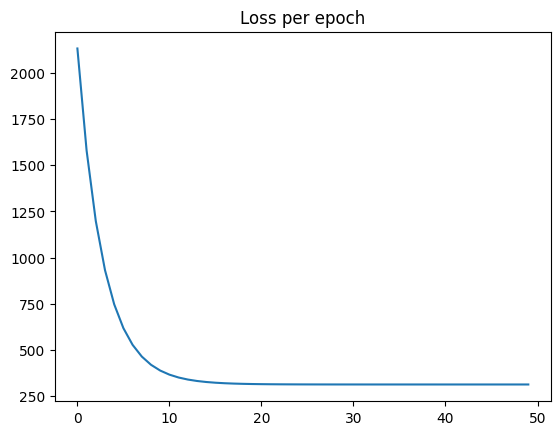

In [8]:
print('b:', model.W[0,0])
print('W:', model.W[0,1])
plt.plot(loss_history)
plt.title('Loss per epoch')

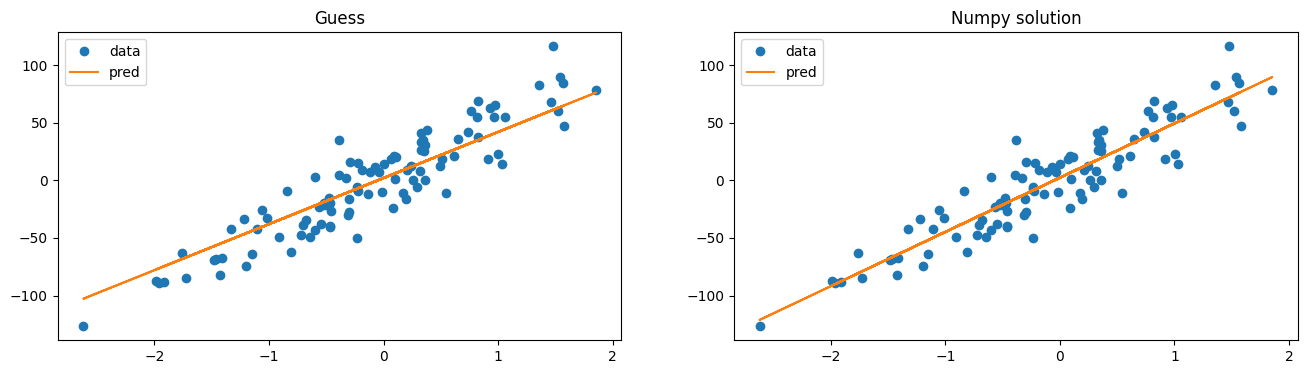

In [9]:
# Vis
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(X, y, "o", label="data")
axs[0].plot(X, 40*X + 2, "-", label="pred")
axs[0].set_title("Guess")
axs[0].legend();

axs[1].plot(X, y, "o", label="data")
axs[1].plot(X, y_hat, "-", label="pred")
axs[1].set_title("Numpy solution")
axs[1].legend();

# Numpy + Autograd Solution

In the previous implementation, we had to derive the gradient $\frac{\partial MSE(\theta)}{\partial \theta}$ manually. If the model $f(\cdot;\theta)$ is more complex, this might be a cumbersome and error-prone task. To avoid this, we will use PyTorch `autograd` to automatically compute gradients.


In [10]:
class MixedLinearRegression(object):
    def __init__(self, n_features, n_targets=1, lr=0.01):
        # note requires_grad=True!
        self.W = torch.zeros(n_targets, n_features, requires_grad=True)
        self.lr = lr

    def update_weight(self):
        # Gradients are given to us by autograd!
        self.W.data = self.W.data - self.lr * self.W.grad.data

    def loss(self, y_hat, y):
        return torch.mean(torch.pow(y - y_hat, 2))

    def predict(self, X):
        return torch.matmul(X, self.W.t()).squeeze(-1)

    def train(self, X, y, epochs=50):
        """
        X (n_examples x n_features): input matrix
        y (n_examples): gold labels
        """
        loss_history = []
        for _ in range(epochs):
            # Our neural net is a Line function!
            y_hat = self.predict(X)

            # Compute the loss using torch operations so they are saved in the gradient history.
            loss = self.loss(y_hat, y)

            # Computes the gradient of loss with respect to all Variables with requires_grad=True.
            # where Variables are tensors with requires_grad=True
            loss.backward()
            loss_history.append(loss.item())

            # Update weights using gradient descent; W.data is a Tensor.
            self.update_weight()

            # Reset the accumulated gradients
            self.W.grad.data.zero_()

        return loss_history

In [11]:
X_pt = torch.from_numpy(X_np).float()
y_pt = torch.from_numpy(y).float()

In [12]:
model = MixedLinearRegression(n_features=n_features, n_targets=1, lr=0.1)
loss_history = model.train(X_pt, y_pt, epochs=50)
with torch.no_grad():
    y_hat = model.predict(X_pt)

b: 2.3264429569244385
W: 47.12483596801758


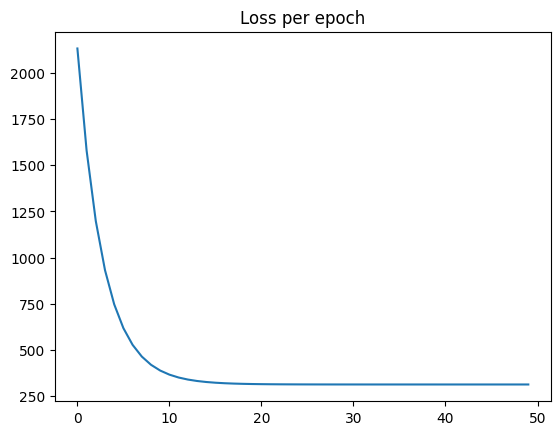

In [13]:
print('b:', model.W[0,0].item())
print('W:', model.W[0,1].item())
plt.plot(loss_history)
plt.title('Loss per epoch');

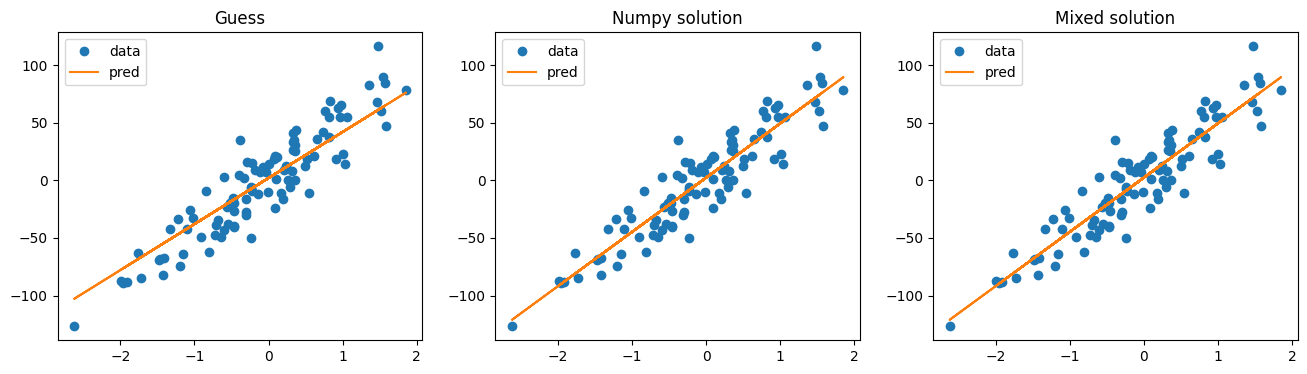

In [14]:
# Vis
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].plot(X, y, "o", label="data")
axs[0].plot(X, 40*X + 2, "-", label="pred")
axs[0].set_title("Guess")
axs[0].legend();

axs[1].plot(X, y, "o", label="data")
axs[1].plot(X, 47.12483907744531*X + 2.3264433961431727, "-", label="pred")
axs[1].set_title("Numpy solution")
axs[1].legend();

axs[2].plot(X, y, "o", label="data")
axs[2].plot(X, y_hat, "-", label="pred")
axs[2].set_title("Mixed solution")
axs[2].legend();

# PyTorch Solution

Mixing PyTorch and Numpy is no fun. PyTorch is actually very powerful and provides most of the things we need to apply gradient descent for any model $f$, as long all operations applied over the inputs are Torch operations (so gradients can be tracked).

To this end, we will use the submodule `torch.nn`, which provides us a way for encapsulating our model into a `nn.Module`. With this, all we need to do is define the our parameters in the `__init__` method and then the _forward_ pass of our model in the `forward` method.

In [15]:
from torch import nn
from torch import optim

# See the inheritance from nn.Module
class TorchLinearRegression(nn.Module):

    def __init__(self, n_features, n_targets=1):
        super().__init__()  # this is mandatory!

        # encapsulate our weights into a nn.Parameter object
        self.W = torch.nn.Parameter(torch.zeros(n_targets, n_features))
        print("This is the features: - ",n_features)
        print("This is the weight: - ",self.W)

    def forward(self, X):
        """
        X (n_examples x n_features): input matrix
        """
        #if self.training:
        #    X = X ** 2
        #else:
        #    X = X ** 3
        #    import ipdb; ipdb. set_trace()
        # print("This is the Input: - ",X)
        return X @ self.W.t()

In [16]:
# define model, loss function and optmizer
model = TorchLinearRegression(n_features)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# move to CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
X = X_pt.to(device)
y = y_pt.to(device).unsqueeze(-1)
# print("This is the Input: - ",X)

This is the features: -  2
This is the weight: -  Parameter containing:
tensor([[0., 0.]], requires_grad=True)


All done! Now we just have to write a training loop, which is more or less a standard set of steps for training all models:

In [17]:
def train(model, X, y, epochs=50):
    # inform PyTorch that we are in "training" mode
    model.train()

    loss_history = []
    for _ in range(epochs):
        # reset gradients before learning
        optimizer.zero_grad()

        # get predictions and and the final score from the loss function
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss_history.append(loss.item())

        # compute gradients of the loss wrt parameters
        loss.backward()

        # perform gradient step to update the parameters
        optimizer.step()

    return loss_history

In [18]:
def evaluate(model, X):
    # inform PyTorch that we are in "evaluation" mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():
        # get prediction
        y_hat = model(X)

    return y_hat

In [19]:
loss_history = train(model, X, y, epochs=50)
y_hat = evaluate(model, X)

b: 2.3264429569244385
W: 47.12483596801758


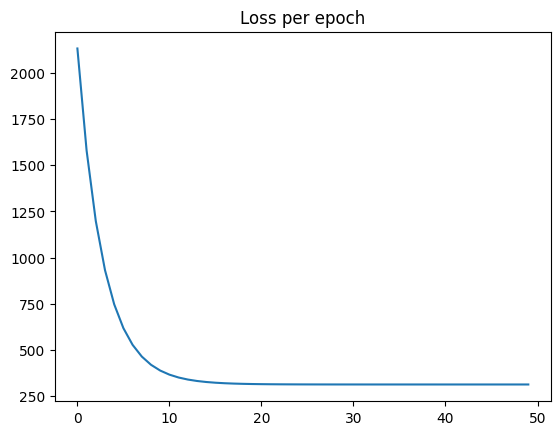

In [20]:
print('b:', model.W[0,0].item())
print('W:', model.W[0,1].item())
plt.plot(loss_history)
plt.title('Loss per epoch');

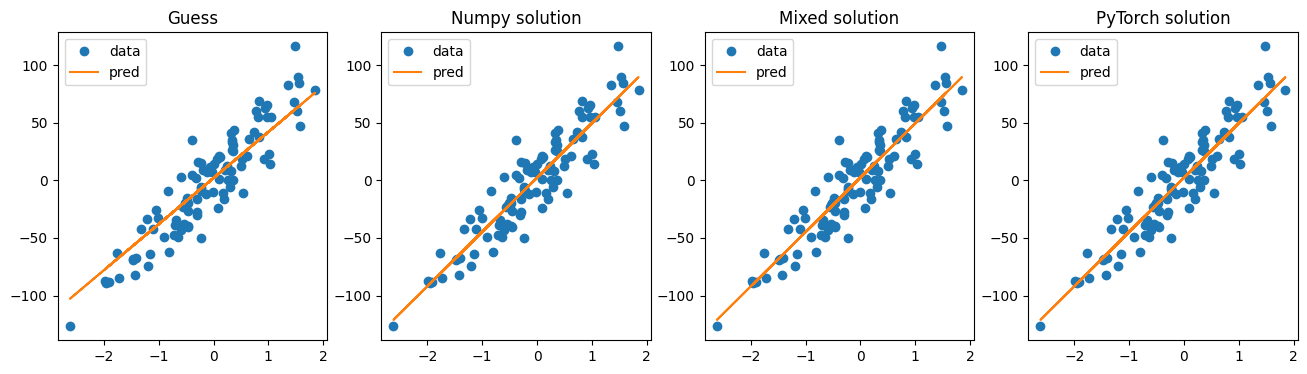

In [21]:
# Vis
X = X_pt[:, 1:].numpy()
y = y_pt.squeeze(-1).numpy()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].plot(X, y, "o", label="data")
axs[0].plot(X, 40*X + 2, "-", label="pred")
axs[0].set_title("Guess")
axs[0].legend();

axs[1].plot(X, y, "o", label="data")
axs[1].plot(X, 47.12483907744531*X + 2.3264433961431727, "-", label="pred")
axs[1].set_title("Numpy solution")
axs[1].legend();

axs[2].plot(X, y, "o", label="data")
axs[2].plot(X, 47.12483596801758*X + 2.3264429569244385, "-", label="pred")
axs[2].set_title("Mixed solution")
axs[2].legend();

axs[3].plot(X, y, "o", label="data")
axs[3].plot(X, y_hat, "-", label="pred")
axs[3].set_title("PyTorch solution")
axs[3].legend();

**Note:** I did gradient descent with the entire dataset rather than splitting the data into `train` and `valid` subsets, which should be done in practice!

## Exercises

- Write a proper training loop for PyTorch:
  - add support for batches
  - add a stop criterion for the convergence of the model
  
- Add L2 regularization

In [22]:
# define model, loss function and optmizer
model = TorchLinearRegression(n_features)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(
                      model.parameters(),
                      lr=0.1,
                      weight_decay=1e-4
                    )

# move to CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
X = X_pt.to(device)
y = y_pt.to(device).unsqueeze(-1)
# print("This is the Input: - ",X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


This is the features: -  2
This is the weight: -  Parameter containing:
tensor([[0., 0.]], requires_grad=True)


/tmp/ipython-input-1631005731.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipython-input-1631005731.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


In [23]:
def train(model, X, y, epochs=50, batch_size=20):
    model.train()
    N = X.shape[0]
    loss_history = []

    for _ in range(epochs):
        perm = torch.randperm(N)
        X_shuffled = X
        y_shuffled = y

        for i in range(0, N, batch_size):
            xb = X_shuffled[i:i+batch_size]
            yb = y_shuffled[i:i+batch_size]

            optimizer.zero_grad()
            y_hat = model(xb)
            loss = loss_fn(y_hat, yb)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())

    return loss_history


In [24]:
def evaluate(model, X):
    # inform PyTorch that we are in "evaluation" mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():
        # get prediction
        y_hat = model(X)

    return y_hat

In [25]:
loss_history = train(model, X, y, epochs=50)
y_hat_L2 = evaluate(model, X)

b: 2.955247402191162
W: 47.215980529785156


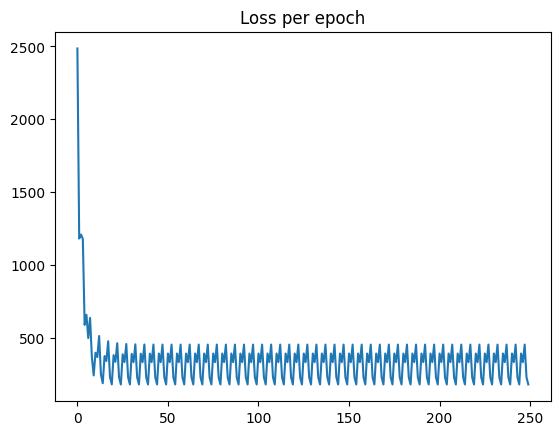

In [26]:
print('b:', model.W[0,0].item())
print('W:', model.W[0,1].item())
plt.plot(loss_history)
plt.title('Loss per epoch');

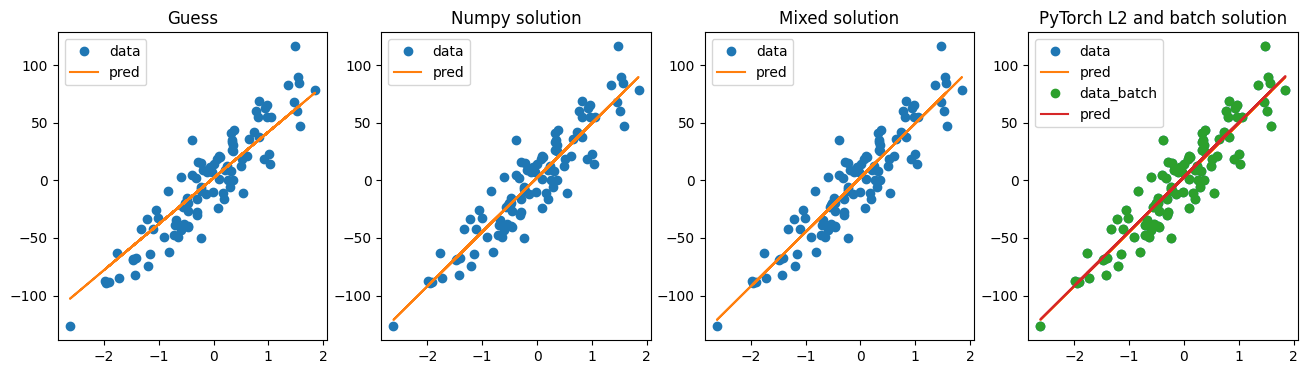

In [28]:
# Vis
X = X_pt[:, 1:].numpy()
y = y_pt.squeeze(-1).numpy()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].plot(X, y, "o", label="data")
axs[0].plot(X, 40*X + 2, "-", label="pred")
axs[0].set_title("Guess")
axs[0].legend();

axs[1].plot(X, y, "o", label="data")
axs[1].plot(X, 47.12483907744531*X + 2.3264433961431727, "-", label="pred")
axs[1].set_title("Numpy solution")
axs[1].legend();

axs[2].plot(X, y, "o", label="data")
axs[2].plot(X, 47.12483596801758*X + 2.3264429569244385, "-", label="pred")
axs[2].set_title("Mixed solution")
axs[2].legend();

axs[3].plot(X, y, "o", label="data")
axs[3].plot(X, y_hat, "-", label="pred")
axs[3].set_title("PyTorch solution")
axs[3].legend();

axs[3].plot(X, y, "o", label="data_batch")
axs[3].plot(X, y_hat_L2, "-", label="pred")
axs[3].set_title("PyTorch L2 and batch solution")
axs[3].legend();